In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Import data and process data

In [54]:
# Read the dataset into the dataframe
df = pd.read_csv('diabetic_data.csv')

## **EDA**

In [ ]:
df.shape # Check the size of the dataset

In [ ]:
df.info() # Check the overall information

In [ ]:
df.isnull().sum() # Check the missing values

In [ ]:
df.duplicated().sum() # Check the duplicate values

In [ ]:
for i in df.select_dtypes(include='object').columns:
  print(df[i].value_counts())
  print('---' * 10)

In [ ]:
df.describe().T # Check the numerical data values

Numerical data Distribution

In [ ]:
for i in df.select_dtypes(include='number').columns:
  sns.histplot(data = df, x = i)
  plt.show()

Age and Gender Count

In [ ]:
# Age and Gender Count
age_count = df["age"].value_counts()
gender_count = df["gender"].value_counts()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
age_count.plot(kind='bar', ax=ax1, color='skyblue')
gender_count.plot(kind='bar', ax=ax2, color='lightcoral')

Race and Weight Count

In [ ]:
# Race and Weight Count
race_count = df["race"].value_counts()
weight_count = df["weight"].value_counts()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
race_count.plot(kind='bar', ax=ax1, color='mediumseagreen')
weight_count.plot(kind='bar', ax=ax2, color='goldenrod')

Readmission Rate Count

In [ ]:
#Readmission Rate Count
target_count = df['readmitted'].value_counts()
target_count.plot(kind = 'bar', title= 'Readmission Count')

In [ ]:
# correlation heatmap to visualize how strongly numerical featuresare related to each other.
corr = df.select_dtypes(include = 'number').corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
df.columns # To divide them into diagnosis_cols and

Diagnosis vs Readmission

In [ ]:
diagnosis_cols = ['diag_1', 'diag_2', 'diag_3']

# Diagnosis vs Readmission
for diag in diagnosis_cols:
    plt.figure(figsize=(10, 5))
    top10 = df[diag].value_counts().iloc[:10].index  # Top 10 frequent diagnoses
    sns.countplot(data=df[df[diag].isin(top10)], x=diag, hue='readmitted')
    plt.title(f'{diag} vs Readmission')
    plt.xticks(rotation=45)
    plt.show()

Medications vs Readmission

In [ ]:
medication_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'examide', 'citoglipton', 'insulin',
    'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone'
]

# Medications vs Readmission
for med in medication_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=med, hue='readmitted')
    plt.title(f'{med} Usage vs Readmission')
    plt.xticks(rotation=45)
    plt.show()

# **Data Processing**

In [ ]:
missing_info = []

# Check missing values for object columns
for col in df.select_dtypes(include = 'object').columns:
        count_missing = df[col][df[col] == '?'].count()
        percent_missing = (count_missing / df.shape[0] * 100).round(2)
        missing_info.append([col, count_missing, percent_missing])

# Create DataFrame from collected missing info
missing_value = pd.DataFrame(missing_info, columns=["col", "count_missing", "percent_missing"])
missing_value = missing_value.sort_values(by="percent_missing", ascending=False)

missing_value

In [55]:
# Drop 3 columns with too many missing '?'
df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

# Drop rows based on multiple cleaning conditions:
df = df.drop(df[
    # Drop if all three diagnosis columns are missing ('?')
    ((df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')) |

    # Drop specific 'admission_type_id' values: 5 (Not Available), 6 (NULL), 8 (Not Mapped)
    (df['admission_type_id'].isin([5, 6, 8])) |

    # Drop 'discharge_disposition_id' values indicating death or irrelevant outcomes
    (df['discharge_disposition_id'].isin([11, 13, 14, 18, 19, 20, 21, 25, 26])) |

    # Drop 'admission_source_id' values that are unavailable, NULL, or not mapped
    (df['admission_source_id'].isin([9, 15, 17, 20, 21]))
].index)


In [ ]:
df.shape # Check th dimension now

In [56]:
# Drop missing values in gender
df = df.drop(df[df['gender'] == 'Unknown/Invalid'].index)

# Drop missing values in race
df = df.drop(df[df['race'] == '?'].index)

In [ ]:
df.shape # Check th dimension now

In [ ]:
df['patient_nbr'].value_counts()

In [ ]:
df['citoglipton'].value_counts()
df['examide'].value_counts()

In [57]:
# Drop irrelevant variables
df = df.drop(["encounter_id"],axis=1)
df = df.drop(["citoglipton","examide"],axis = 1)

In [ ]:
df.shape # Check th dimension now

In [ ]:
df['readmitted'].value_counts() # Just to check the difference

In [ ]:
df.isnull().sum()

In [ ]:
df['max_glu_serum'].value_counts().sum()

In [ ]:
df['A1Cresult'].value_counts().sum()

In [58]:
# Drop max_glu_serum, A1Cresult because it's almost entirely missing
df.drop(['max_glu_serum', 'A1Cresult'], axis=1, inplace=True)

In [ ]:
df.shape # Check th dimension now

 Decode ID Columns Using Mapping:

In [59]:
# Decoding IDs using mapping file
admission_type_map = {
    1: 'Emergency',
    2: 'Urgent',
    3: 'Elective',
    4: 'Newborn',
    7: 'Trauma Center',
}

discharge_disposition_map = {
    1: 'Discharged to home',
    2: 'Discharged/transferred to another short term hospital',
    3: 'Discharged/transferred to SNF',
    4: 'Discharged/transferred to ICF',
    5: 'Discharged/transferred to another type of inpatient care institution',
    6: 'Discharged/transferred to home with home health service',
    7: 'Left AMA',
    8: 'Discharged/transferred to home under care of Home IV provider',
    9: 'Admitted as an inpatient to this hospital',
    10: 'Neonate discharged to another hospital for neonatal aftercare',
    12: 'Still patient or expected to return for outpatient services',
    15: 'Discharged/transferred within this institution to Medicare approved swing bed',
    16: 'Discharged/transferred/referred another institution for outpatient services',
    17: 'Discharged/transferred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
    22: 'Discharged/transferred to another rehab facility including rehab units of a hospital',
    23: 'Discharged/transferred to a long term care hospital',
    24: 'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare',
}

admission_source_map = {
    1: 'Physician Referral',
    2: 'Clinic Referral',
    3: 'HMO Referral',
    4: 'Transfer from a hospital',
    5: 'Transfer from a Skilled Nursing Facility (SNF)',
    6: 'Transfer from another health care facility',
    7: 'Emergency Room',
    8: 'Court/Law Enforcement',
    10: 'Transfer from critical access hospital',
    11: 'Normal Delivery',
    12: 'Premature Delivery',
    13: 'Sick Baby',
    14: 'Extramural Birth',
}

df['admission_type_id'] = df['admission_type_id'].replace(admission_type_map)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(discharge_disposition_map)
df['admission_source_id'] = df['admission_source_id'].replace(admission_source_map)

In [60]:
# Adding some important features
df['total_visits'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['missing_diag'] = ((df['diag_1'] == '?') | (df['diag_2'] == '?') | (df['diag_3'] == '?')).astype(int)

# List of medication columns
# Create a new variable to calculate the change of medication dose
meds_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide',
    'metformin-pioglitazone', 'metformin-rosiglitazone', 'glimepiride-pioglitazone',
    'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide'
]

# Create new binary columns: 1 if med was changed (up or down), 0 if no change or steady (Some encoding)
for col in meds_cols:
    new_col = f"{col}_new"
    df[new_col] = df[col].apply(lambda x: 0 if x in ['No', 'Steady'] else 1)

# Sum up all the med changes to create a 'med_change' feature
df['med_change'] = df[[f"{col}_new" for col in meds_cols]].sum(axis=1)

# Drop the temporary binary columns
df.drop(columns=[f"{col}_new" for col in meds_cols], inplace=True)

In [ ]:
df['med_change'].value_counts() #Number of meds with dose change

In [61]:
# Recode medication columns: 'No' → 0, all others ('Steady', 'Up', 'Down') → 1
for col in meds_cols:
    df[col] = df[col].replace({'No': 0, 'Steady': 1, 'Up': 1, 'Down': 1})

# Create 'num_med' feature: sum across the medication columns
df['num_med'] = df[meds_cols].sum(axis=1)

C:\Users\mohamed\AppData\Local\Temp\ipykernel_21288\3211932905.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'No': 0, 'Steady': 1, 'Up': 1, 'Down': 1})


In [ ]:
df['num_med'].value_counts() #Number of active medications

In [62]:
# calculate the outcome variable readmission
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

In [63]:
highly_imbalanced_cols = [ 'glyburide-metformin', 'rosiglitazone', 'pioglitazone', 'glyburide', 'glimepiride', 'nateglinide', 'repaglinide', 'glipizide', 'metformin', 'metformin-rosiglitazone',
    'glimepiride-pioglitazone', 'metformin-pioglitazone', 'troglitazone', 'acetohexamide',
    'glipizide-metformin', 'tolbutamide', 'tolazamide', 'miglitol', 'acarbose', 'chlorpropamide',
]
df.drop(columns=highly_imbalanced_cols, inplace=True)

In [ ]:
df.columns

In [64]:
# Safe numeric conversion first
df['diag_1_num'] = pd.to_numeric(df['diag_1'], errors='coerce')
df['diag_2_num'] = pd.to_numeric(df['diag_2'], errors='coerce')
df['diag_3_num'] = pd.to_numeric(df['diag_3'], errors='coerce')

# Initialize new columns
df['diag_1_code'] = 0
df['diag_2_code'] = 0
df['diag_3_code'] = 0

# Mapping for diag_1
df.loc[df['diag_1'].astype(str).str.startswith('V'), 'diag_1_code'] = 1
df.loc[df['diag_1'].astype(str).str.startswith('E'), 'diag_1_code'] = 2
df.loc[((df['diag_1_num'] >= 390) & (df['diag_1_num'] < 460)) | (df['diag_1_num'] == 785), 'diag_1_code'] = 3
df.loc[((df['diag_1_num'] >= 460) & (df['diag_1_num'] < 520)) | (df['diag_1_num'] == 786), 'diag_1_code'] = 4
df.loc[((df['diag_1_num'] >= 520) & (df['diag_1_num'] < 580)) | (df['diag_1_num'] == 787), 'diag_1_code'] = 5
df.loc[(df['diag_1_num'] >= 250) & (df['diag_1_num'] < 251), 'diag_1_code'] = 6
df.loc[(df['diag_1_num'] >= 800) & (df['diag_1_num'] < 1000), 'diag_1_code'] = 7
df.loc[(df['diag_1_num'] >= 710) & (df['diag_1_num'] < 740), 'diag_1_code'] = 8
df.loc[((df['diag_1_num'] >= 580) & (df['diag_1_num'] < 630)) | (df['diag_1_num'] == 788), 'diag_1_code'] = 9
df.loc[(df['diag_1_num'] >= 140) & (df['diag_1_num'] < 240), 'diag_1_code'] = 10

# Mapping for diag_2
df.loc[df['diag_2'].astype(str).str.startswith('V'), 'diag_2_code'] = 1
df.loc[df['diag_2'].astype(str).str.startswith('E'), 'diag_2_code'] = 2
df.loc[((df['diag_2_num'] >= 390) & (df['diag_2_num'] < 460)) | (df['diag_2_num'] == 785), 'diag_2_code'] = 3
df.loc[((df['diag_2_num'] >= 460) & (df['diag_2_num'] < 520)) | (df['diag_2_num'] == 786), 'diag_2_code'] = 4
df.loc[((df['diag_2_num'] >= 520) & (df['diag_2_num'] < 580)) | (df['diag_2_num'] == 787), 'diag_2_code'] = 5
df.loc[(df['diag_2_num'] >= 250) & (df['diag_2_num'] < 251), 'diag_2_code'] = 6
df.loc[(df['diag_2_num'] >= 800) & (df['diag_2_num'] < 1000), 'diag_2_code'] = 7
df.loc[(df['diag_2_num'] >= 710) & (df['diag_2_num'] < 740), 'diag_2_code'] = 8
df.loc[((df['diag_2_num'] >= 580) & (df['diag_2_num'] < 630)) | (df['diag_2_num'] == 788), 'diag_2_code'] = 9
df.loc[(df['diag_2_num'] >= 140) & (df['diag_2_num'] < 240), 'diag_2_code'] = 10

# Mapping for diag_3
df.loc[df['diag_3'].astype(str).str.startswith('V'), 'diag_3_code'] = 1
df.loc[df['diag_3'].astype(str).str.startswith('E'), 'diag_3_code'] = 2
df.loc[((df['diag_3_num'] >= 390) & (df['diag_3_num'] < 460)) | (df['diag_3_num'] == 785), 'diag_3_code'] = 3
df.loc[((df['diag_3_num'] >= 460) & (df['diag_3_num'] < 520)) | (df['diag_3_num'] == 786), 'diag_3_code'] = 4
df.loc[((df['diag_3_num'] >= 520) & (df['diag_3_num'] < 580)) | (df['diag_3_num'] == 787), 'diag_3_code'] = 5
df.loc[(df['diag_3_num'] >= 250) & (df['diag_3_num'] < 251), 'diag_3_code'] = 6
df.loc[(df['diag_3_num'] >= 800) & (df['diag_3_num'] < 1000), 'diag_3_code'] = 7
df.loc[(df['diag_3_num'] >= 710) & (df['diag_3_num'] < 740), 'diag_3_code'] = 8
df.loc[((df['diag_3_num'] >= 580) & (df['diag_3_num'] < 630)) | (df['diag_3_num'] == 788), 'diag_3_code'] = 9
df.loc[(df['diag_3_num'] >= 140) & (df['diag_3_num'] < 240), 'diag_3_code'] = 10

# Optional: Drop intermediate numeric columns if you want
df.drop(['diag_1_num', 'diag_2_num', 'diag_3_num'], axis=1, inplace=True)
df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)


In [65]:
from sklearn.preprocessing import LabelEncoder

label_cols = ['gender', 'change', 'diabetesMed', 'race', 'age',
              'admission_type_id', 'discharge_disposition_id', 'admission_source_id']

le = LabelEncoder()

for col in label_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)  # Convert to string
        df[col] = le.fit_transform(df[col])
        print(f"Encoded column: {col}")
        print(df[col].value_counts())
        print("-" * 40)

Encoded column: gender
gender
0    44538
1    37829
Name: count, dtype: int64
----------------------------------------
Encoded column: change
change
1    43535
0    38832
Name: count, dtype: int64
----------------------------------------
Encoded column: diabetesMed
diabetesMed
1    64072
0    18295
Name: count, dtype: int64
----------------------------------------
Encoded column: race
race
2    62402
0    16657
3     1511
4     1250
1      547
Name: count, dtype: int64
----------------------------------------
Encoded column: age
age
7    20557
6    18467
5    14259
8    13655
4     7907
3     3163
9     2158
2     1429
1      627
0      145
Name: count, dtype: int64
----------------------------------------
Encoded column: admission_type_id
admission_type_id
1    48538
0    17282
4    16520
3       17
2       10
Name: count, dtype: int64
----------------------------------------
Encoded column: discharge_disposition_id
discharge_disposition_id
3     53242
5     11480
12    10978
8      1

In [ ]:
df.shape

In [ ]:
df.columns

In [66]:
df['num_visits'] = df.groupby('patient_nbr')['patient_nbr'].transform('count')

In [ ]:
df['num_visits'].dtype

In [67]:
num_col = list(set(list(df._get_numeric_data().columns)) - {'readmitted'})
num_col

['number_inpatient',
 'patient_nbr',
 'discharge_disposition_id',
 'diabetesMed',
 'diag_3_code',
 'admission_type_id',
 'num_procedures',
 'diag_1_code',
 'num_visits',
 'insulin',
 'gender',
 'admission_source_id',
 'number_outpatient',
 'total_visits',
 'race',
 'med_change',
 'change',
 'num_lab_procedures',
 'number_emergency',
 'number_diagnoses',
 'num_medications',
 'missing_diag',
 'num_med',
 'age',
 'time_in_hospital',
 'diag_2_code']

In [ ]:
df.isnull().sum()

In [52]:
# Handle outliers for all numerical columns

for col in num_col:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clip the outliers
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

In [53]:
for col in df.columns:
    print(f"Value counts for '{col}':")
    print(df[col].value_counts(dropna=False))
    print('-' * 40)


Value counts for 'patient_nbr':
patient_nbr
186667362    83
88785891     40
43140906     28
23199021     23
88227540     23
             ..
160248038     1
30370995      1
44735553      1
141379232     1
175429310     1
Name: count, Length: 58121, dtype: int64
----------------------------------------
Value counts for 'race':
race
2    82367
Name: count, dtype: int64
----------------------------------------
Value counts for 'gender':
gender
0    44538
1    37829
Name: count, dtype: int64
----------------------------------------
Value counts for 'age':
age
7    20557
6    18467
5    14259
8    13655
4     7907
3     3163
2     2201
9     2158
Name: count, dtype: int64
----------------------------------------
Value counts for 'admission_type_id':
admission_type_id
1    82367
Name: count, dtype: int64
----------------------------------------
Value counts for 'discharge_disposition_id':
discharge_disposition_id
3    53242
8    16357
5    11480
4      750
6      368
1      101
7       48
2  

In [69]:
def standardize(dataframe):
    standardized_df = dataframe.copy()

    for col in dataframe.columns:
        unique_vals = dataframe[col].nunique()
        std = dataframe[col].std()

        # Skip constant columns (std = 0)
        if std == 0:
            continue

        # Skip binary columns (like 0/1 or True/False)
        if unique_vals == 2 and sorted(dataframe[col].unique()) in [[0, 1], [False, True]]:
            continue

        # Standardize the column
        mean = dataframe[col].mean()
        standardized_df[col] = (dataframe[col] - mean) / std

    return standardized_df

# Step 4: Apply standardization
df[num_col] = standardize(df[num_col])


In [73]:
df.shape

(82367, 27)

In [72]:
df.columns

Index(['patient_nbr', 'race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'insulin', 'change', 'diabetesMed', 'readmitted',
       'total_visits', 'missing_diag', 'med_change', 'num_med', 'diag_1_code',
       'diag_2_code', 'diag_3_code', 'num_visits'],
      dtype='object')

In [71]:
df['readmitted'].value_counts()

readmitted
0    72914
1     9453
Name: count, dtype: int64

# **EDA**

In [ ]:
df.columns

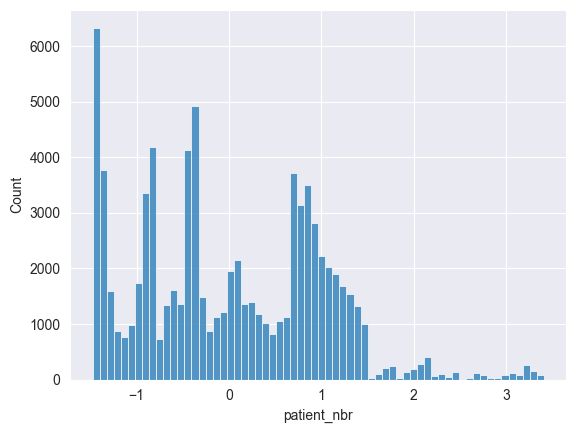

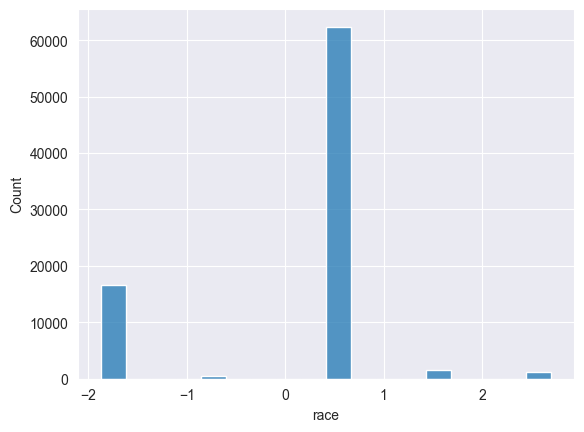

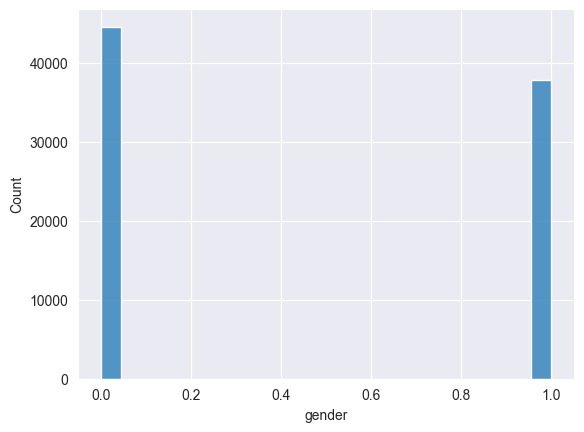

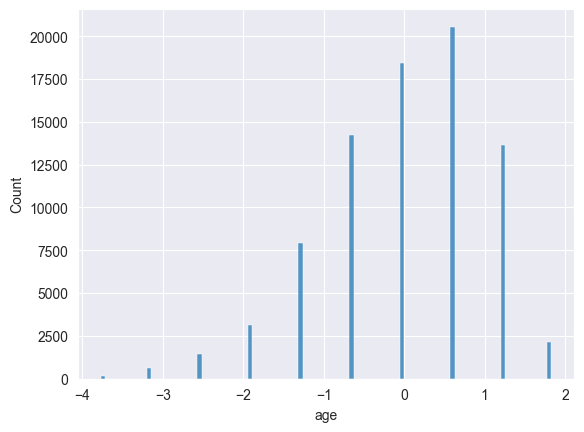

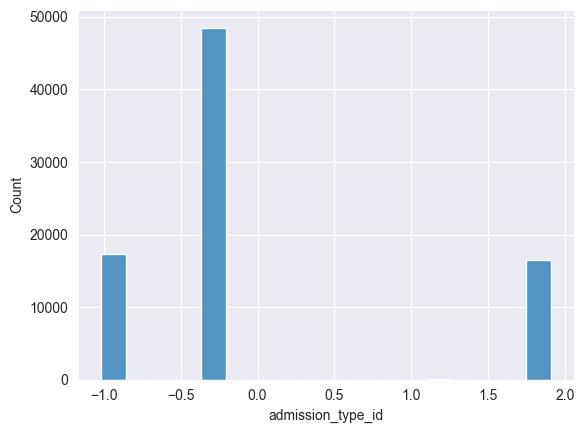

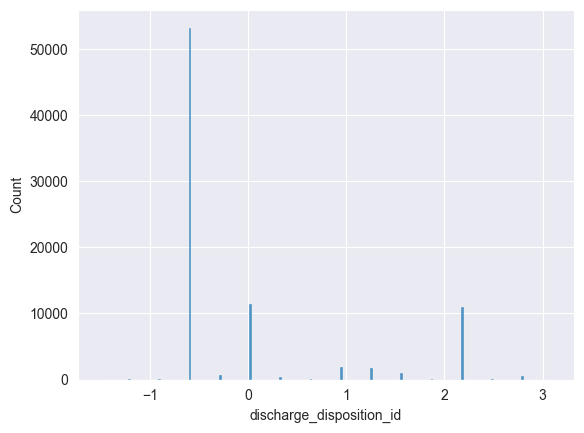

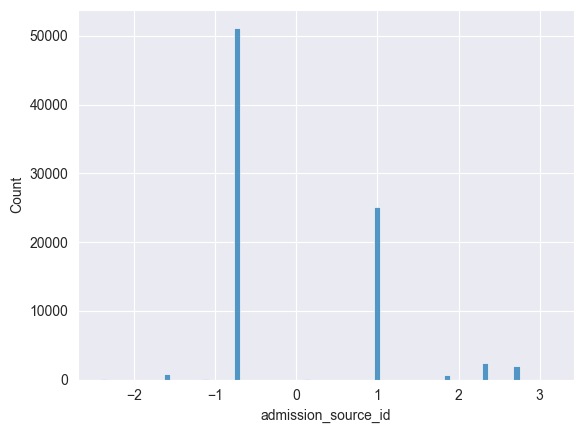

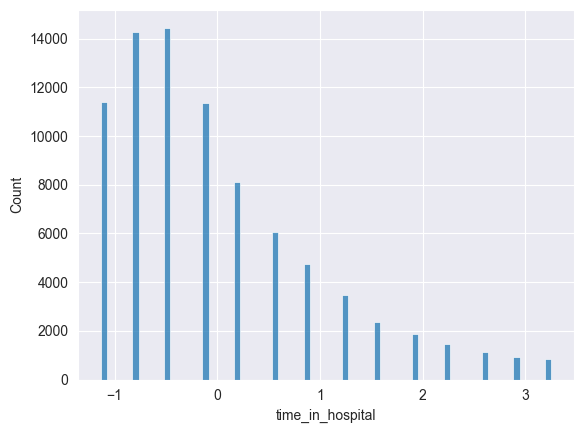

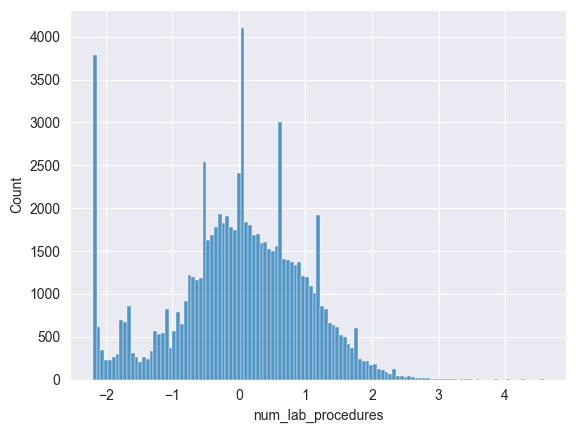

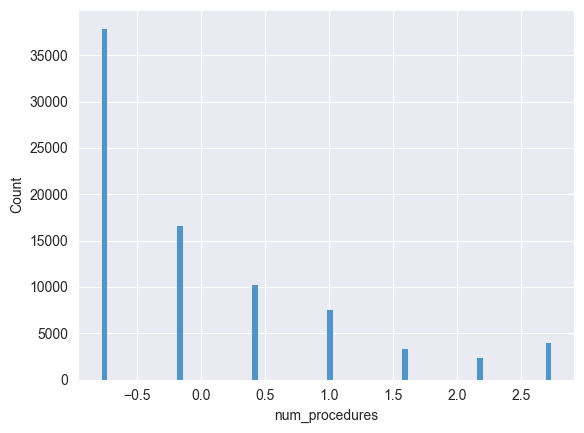

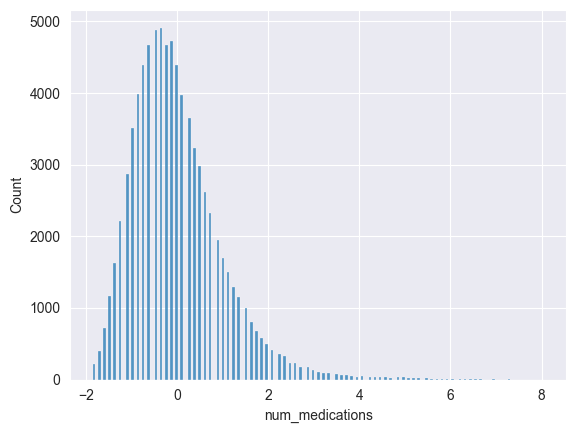

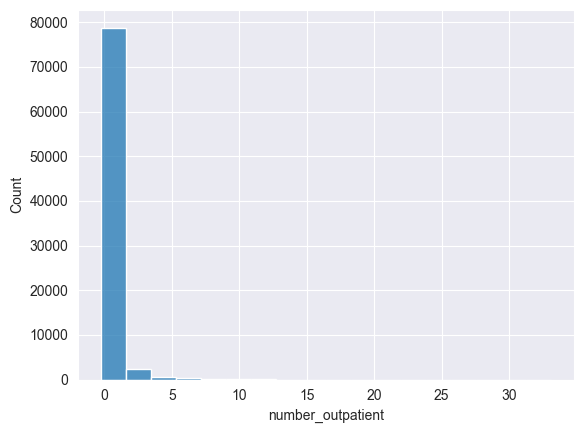

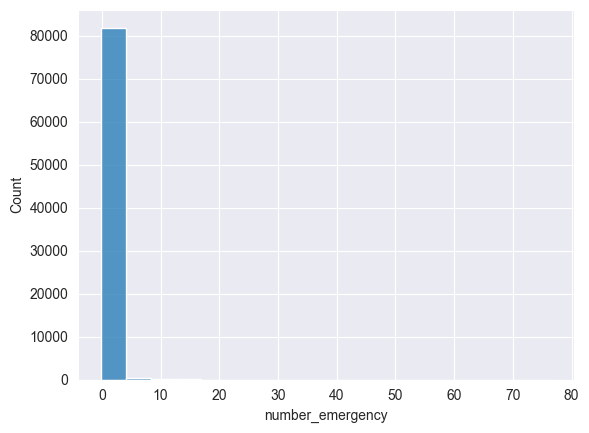

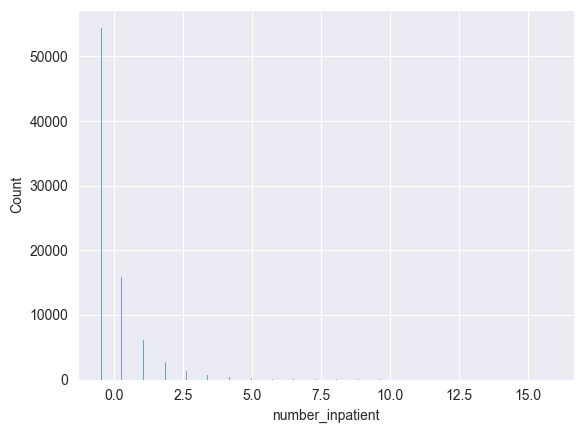

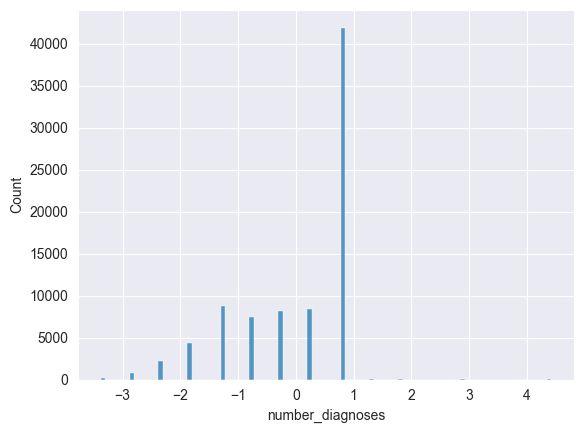

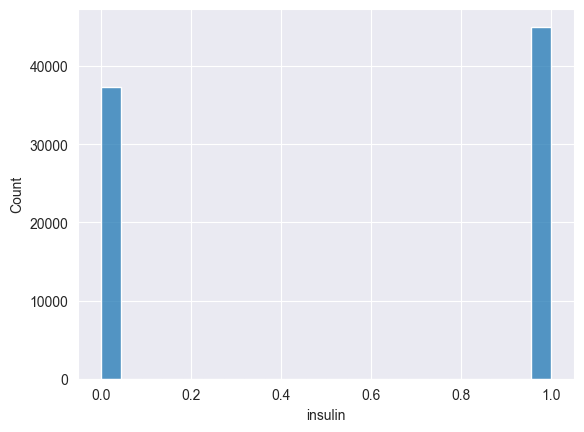

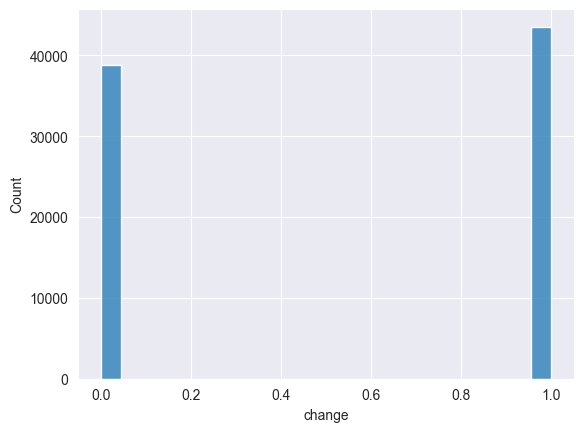

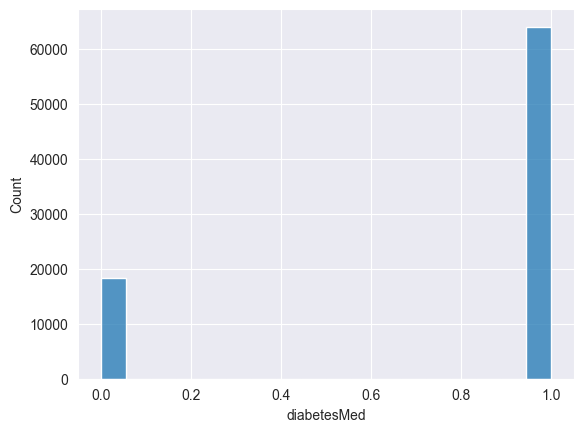

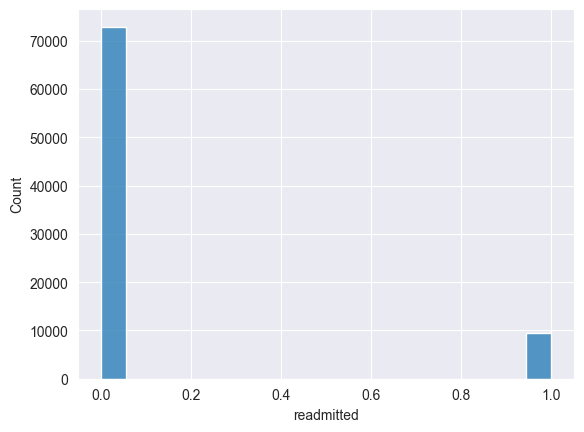

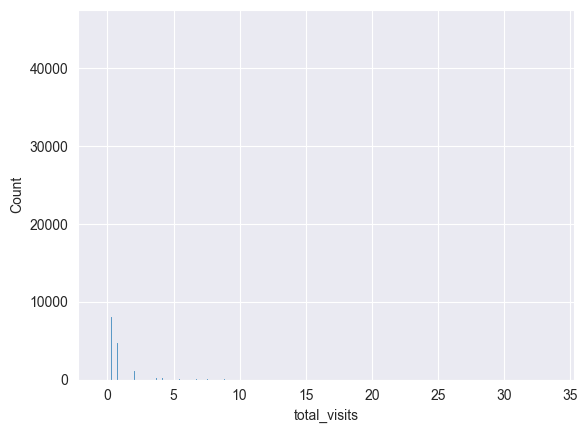

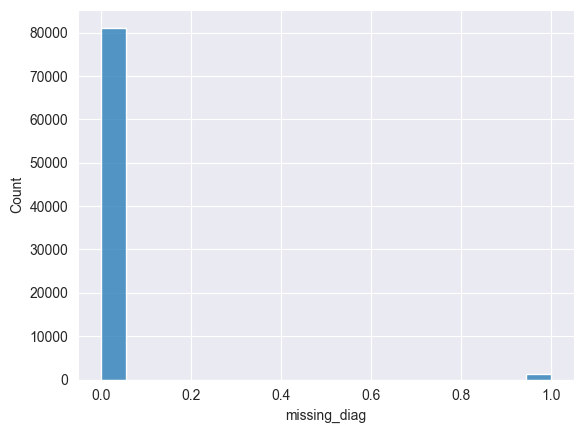

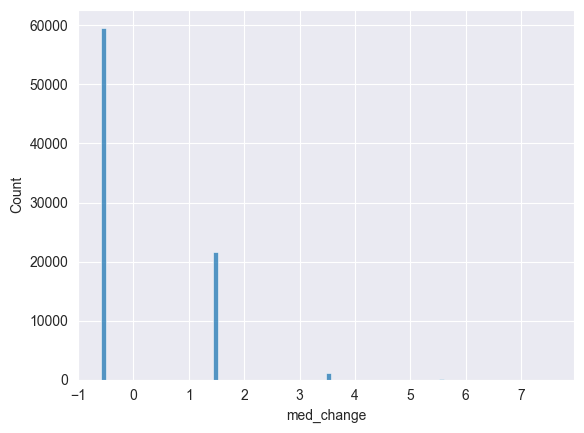

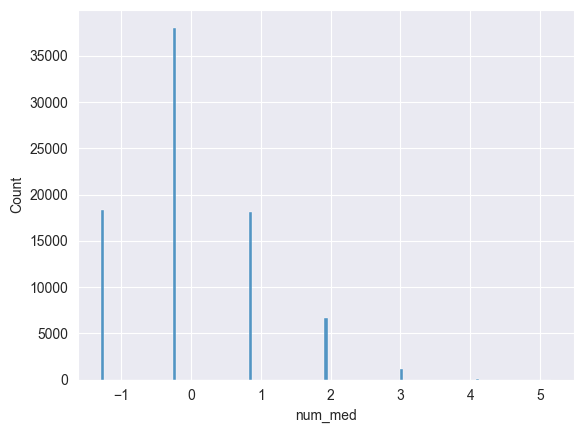

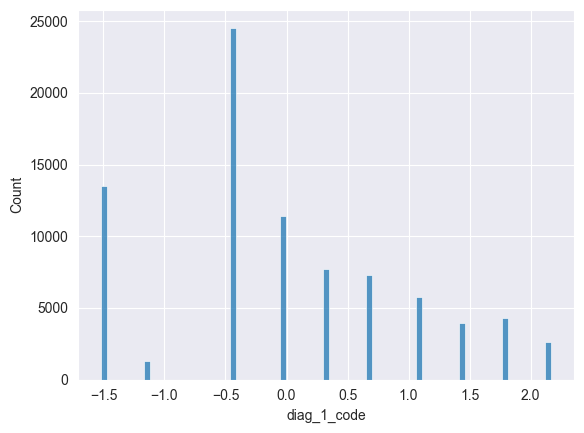

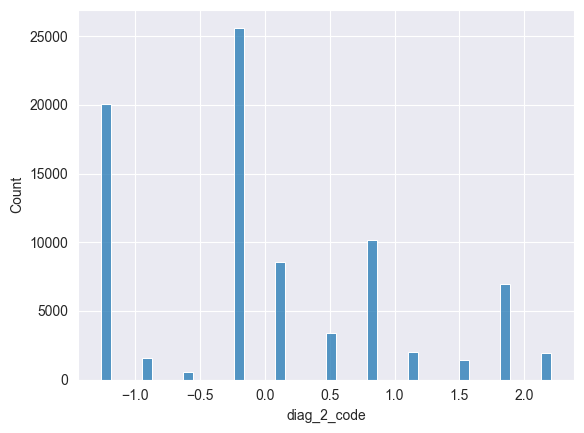

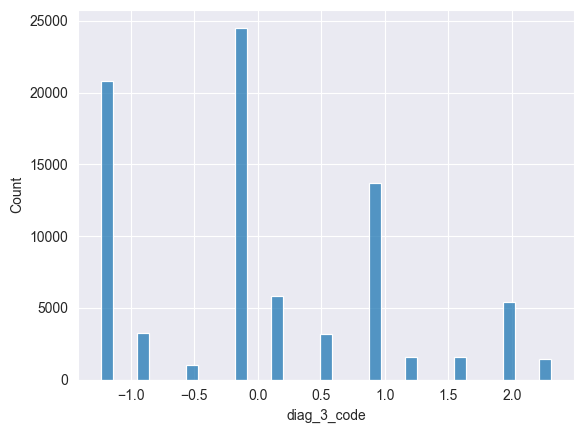

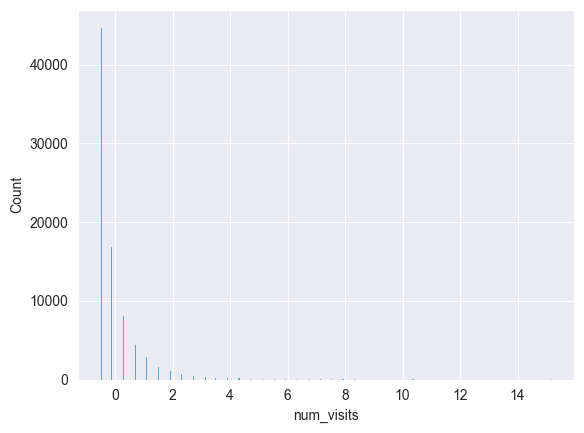

In [74]:
for i in df.select_dtypes(include='number').columns:
  sns.histplot(data = df, x = i)
  plt.show()

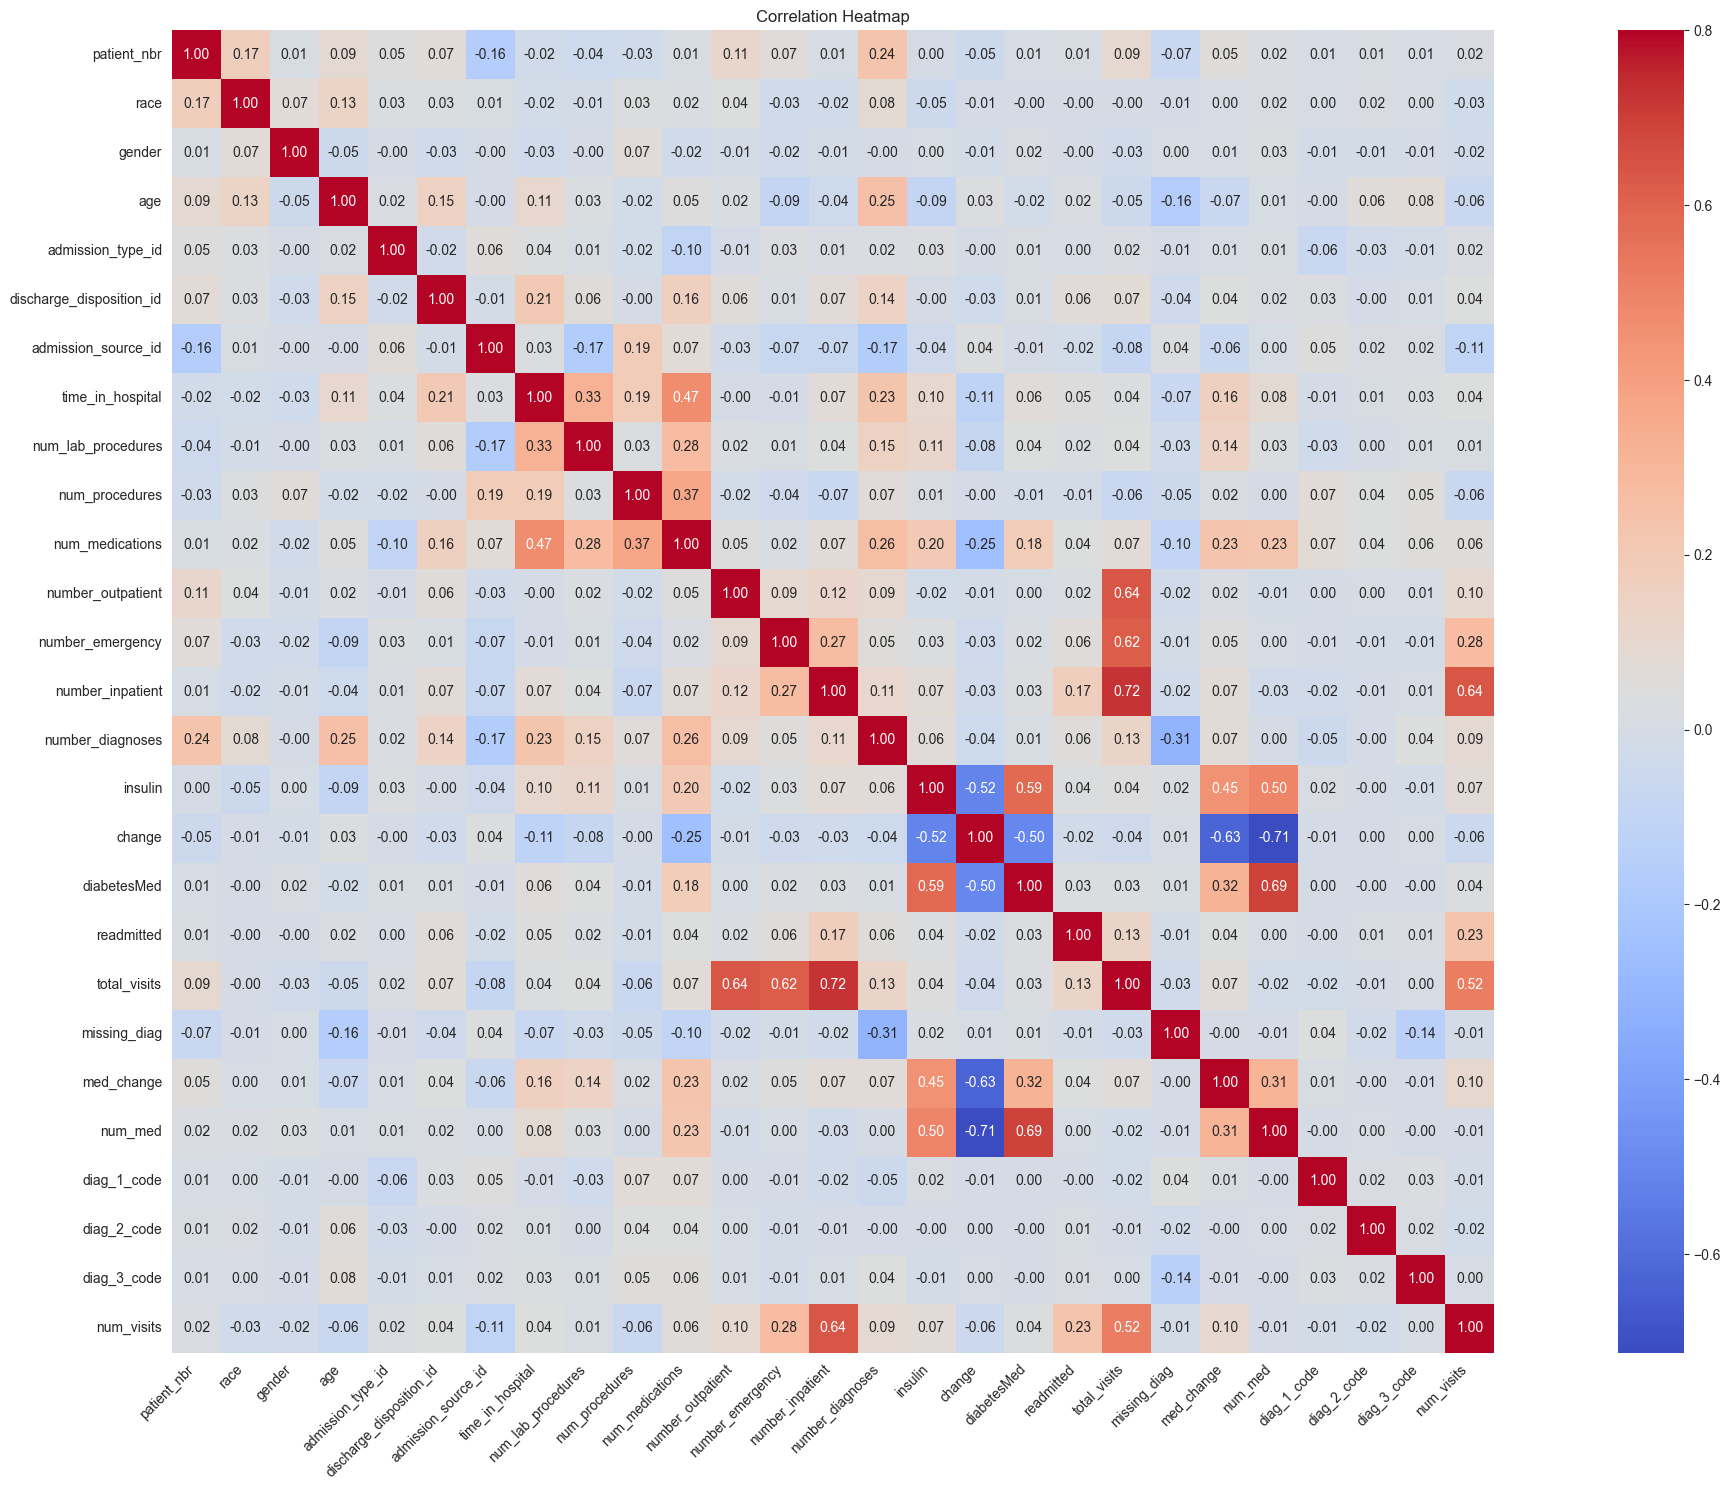

In [75]:
# Compute correlation matrix
df_corr = df.corr()

non_nan_mask = df_corr.notna().any(axis=1)
df_coll_clean = df_corr.loc[non_nan_mask, non_nan_mask]

# Plot cleaned heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(df_coll_clean, vmax=.8, square=True, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
for i in df.columns:
    train = df[i].value_counts()
    print(train)

# **Modeling**

In [77]:
# Test just see if all of the above came with profit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Split features and target
x = df.drop('readmitted', axis=1)
y = df['readmitted']

# Stratified train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

# Logistic Regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(x_train, y_train)

# Predict on test set
y_pred = model.predict(x_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print all results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

Accuracy: 0.7364331674153212
Precision: 0.23271537622682661
Recall: 0.5642517186673718
F1 Score: 0.3295243977764052
Confusion Matrix:
 [[11065  3518]
 [  824  1067]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.76      0.84     14583
           1       0.23      0.56      0.33      1891

    accuracy                           0.74     16474
   macro avg       0.58      0.66      0.58     16474
weighted avg       0.85      0.74      0.78     16474



In [78]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, roc_auc_score
)

# Step 1: Split features and target
X = df.drop('readmitted', axis=1)
y = df['readmitted']

# Step 2: Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

# Step 3: Train Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=0
)
rf_model.fit(X_train, y_train)

# Step 4: Predict
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Needed for ROC-AUC

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Step 6: Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)


Accuracy: 0.8866699040912954
Precision: 0.6764705882352942
Recall: 0.024325753569539928
F1 Score: 0.04696273608984176
ROC-AUC Score: 0.7764651965936301
Confusion Matrix:
 [[14561    22]
 [ 1845    46]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     14583
           1       0.68      0.02      0.05      1891

    accuracy                           0.89     16474
   macro avg       0.78      0.51      0.49     16474
weighted avg       0.86      0.89      0.84     16474



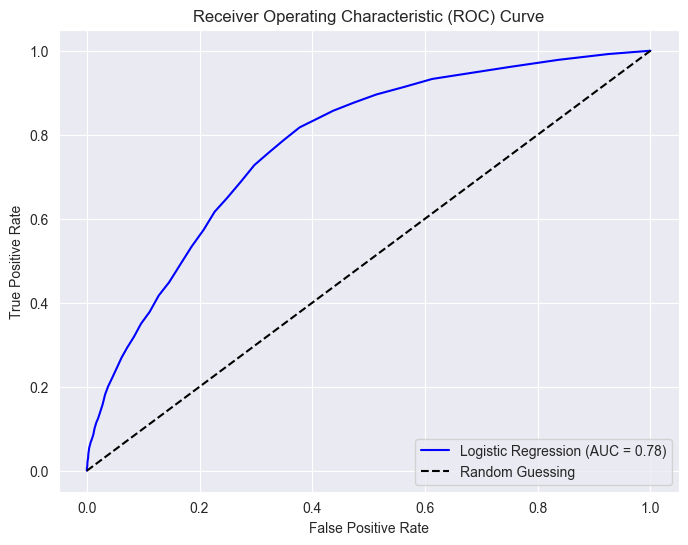

ROC AUC Score: 0.7764651965936301


In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
#ROC AUC

# Predict probabilities for the positive class (class 1)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Compute False Positive Rate, True Positive Rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print AUC Score
print("ROC AUC Score:", roc_auc)


**SMOTE**

In [80]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Assume X, y are your features and target (readmission: 0 or 1)

# Step 1: Split your dataset
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Apply SMOTE to the training set only
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print("Original dataset shape:", y_train.value_counts())
print("Resampled dataset shape:", y_train_resampled.value_counts())


Original dataset shape: readmitted
0    58331
1     7562
Name: count, dtype: int64
Resampled dataset shape: readmitted
0    58331
1    58331
Name: count, dtype: int64


In [81]:

# Step 1: Split features and target
X = df.drop('readmitted', axis=1)
y = df['readmitted']

# Step 2: Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

# Step 3: Train Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=0
)
rf_model.fit(x_train_resampled, y_train_resampled)

# Step 4: Predict
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Needed for ROC-AUC

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Step 6: Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

import joblib
joblib.dump(rf_model, 'random_forest_model.pkl') # save the model for later gui


Accuracy: 0.9743231759135608
Precision: 0.9760051880674449
Recall: 0.7958751983077736
F1 Score: 0.8767841538013399
ROC-AUC Score: 0.9802021130128664
Confusion Matrix:
 [[14546    37]
 [  386  1505]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     14583
           1       0.98      0.80      0.88      1891

    accuracy                           0.97     16474
   macro avg       0.98      0.90      0.93     16474
weighted avg       0.97      0.97      0.97     16474



['random_forest_model.pkl']

True Negatives (TN): 14,577 — non-readmitted correctly predicted.

False Positives (FP): 6 — very few non-readmitted misclassified as readmitted.

False Negatives (FN): 409 — fewer missed readmitted cases.

True Positives (TP): 1,482 — strong correct predictions for readmitted.

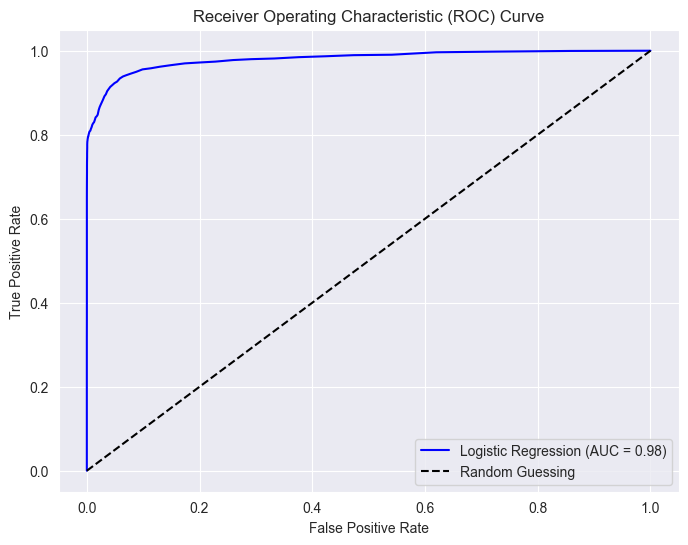

ROC AUC Score: 0.9802021130128664


In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
#ROC AUC

# Predict probabilities for the positive class (class 1)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Compute False Positive Rate, True Positive Rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print AUC Score
print("ROC AUC Score:", roc_auc)


In [83]:
model.fit(x_train_resampled, y_train_resampled)

# Predict on training set
y_train_pred = model.predict(x_train_resampled)

# Predict on test set
y_test_pred = model.predict(X_test)

# Define a function to print metrics
def print_metrics(name, y_true, y_pred):
    print(f"\n{name} Metrics:")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))

# Compare training and test metrics
print_metrics("Training", y_train_resampled, y_train_pred)
print_metrics("Test", y_test, y_test_pred)



Training Metrics:
Accuracy : 0.678704291028784
Precision: 0.6980769961615931
Recall   : 0.6298023349505408
F1 Score : 0.6621844498319168

Test Metrics:
Accuracy : 0.7066893286390676
Precision: 0.20584116823364673
Recall   : 0.5441565309360127
F1 Score : 0.29869375907111756


In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#  Initialize the Decision Tree (ID3-style: uses 'entropy')
dtree = DecisionTreeClassifier(
    criterion='entropy',
     max_depth=4,
    class_weight='balanced',
    random_state=42
)

#  Train on SMOTE-resampled training data
dtree.fit(x_train_resampled, y_train_resampled)

#  Predict on the original test set
y_pred = dtree.predict(X_test)

#  Evaluation
print("Accuracy     :", accuracy_score(y_test, y_pred))
print("Precision    :", precision_score(y_test, y_pred))
print("Recall       :", recall_score(y_test, y_pred))
print("F1 Score     :", f1_score(y_test, y_pred) )


Accuracy     : 0.6956416170936021
Precision    : 0.23716546036020872
Recall       : 0.7451084082496033
F1 Score     : 0.359805924412666


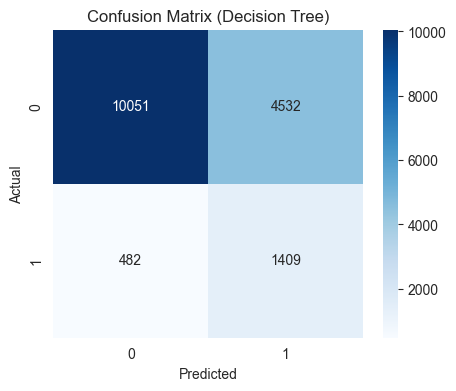

In [85]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()

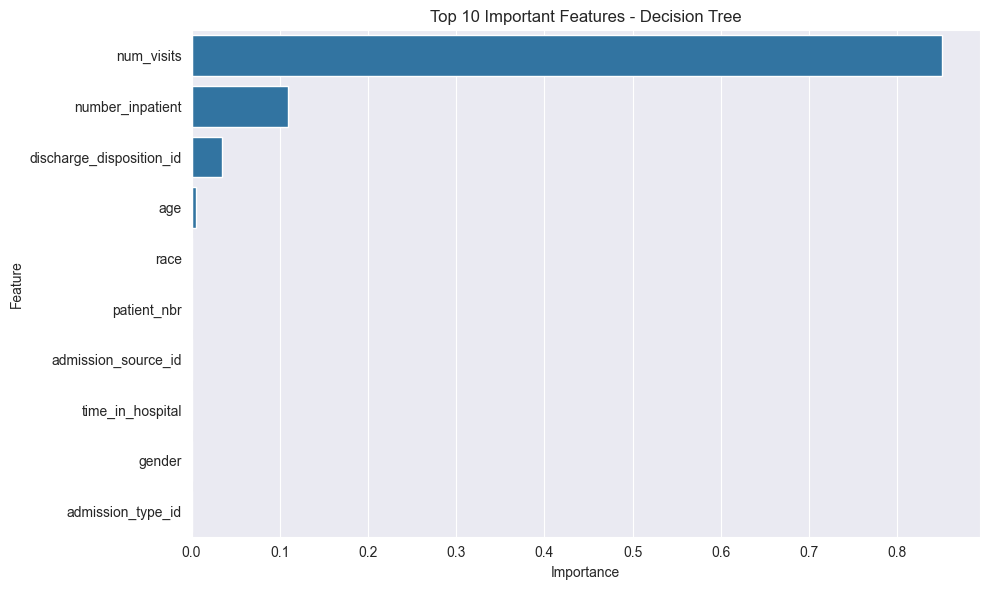

In [86]:
feature_importance = pd.DataFrame({
    'Feature': x_train_resampled.columns,
    'Importance': dtree.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Top 10 Important Features - Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

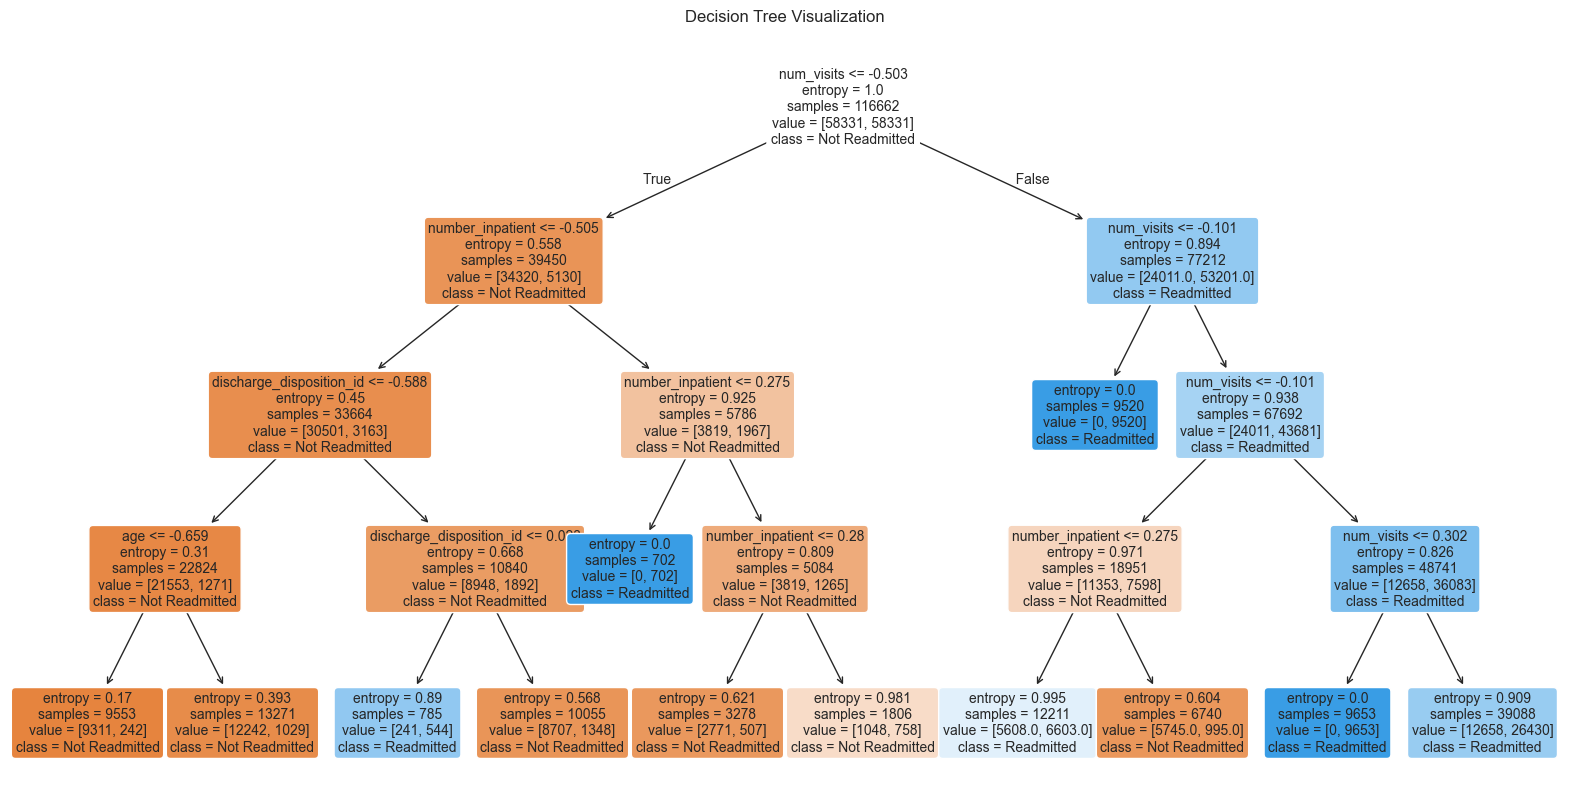

In [87]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dtree,
          filled=True,
          feature_names=x_train_resampled.columns,
          class_names=['Not Readmitted', 'Readmitted'],
          rounded=True,
          fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the SVM model (RBF kernel is default)
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    random_state=42
)

# Train the model on the SMOTE-resampled training data
svm_model.fit(x_train_resampled, y_train_resampled)

# Predict on the original test set
y_pred = svm_model.predict(X_test)

# Evaluation
print("Accuracy     :", accuracy_score(y_test, y_pred))
print("Precision    :", precision_score(y_test, y_pred))
print("Recall       :", recall_score(y_test, y_pred))
print("F1 Score     :", f1_score(y_test, y_pred))


In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SVM)')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report (SVM):\n")
print(classification_report(y_test, y_pred))

In [88]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

neg, pos = (y_train_resampled == 0).sum(), (y_train_resampled == 1).sum()
scale_pos_weight = (neg / pos) *4
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=800,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight
)

model.fit(x_train_resampled, y_train_resampled)

y_pred_proba = model.predict_proba(x_test)[:, 1]

threshold = 0.3
y_pred_thresh = (y_pred_proba >= threshold).astype(int)

print(f"XGBoost Results (Threshold = {threshold}):")
print("Accuracy:", accuracy_score(y_test, y_pred_thresh))
print("Precision:", precision_score(y_test, y_pred_thresh))
print("Recall:", recall_score(y_test, y_pred_thresh))
print("F1 Score:", f1_score(y_test, y_pred_thresh))


C:\Users\mohamed\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:54:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results (Threshold = 0.3):
Accuracy: 0.6255311399781474
Precision: 0.11306078147612156
Recall: 0.33051295610787945
F1 Score: 0.16848631891090443


C:\Users\mohamed\AppData\Local\Temp\ipykernel_21288\893538786.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette='Blues_d')


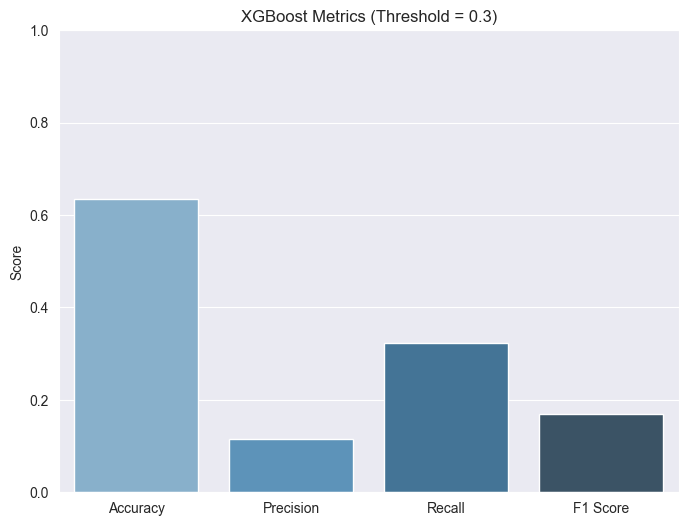

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = {
    'Accuracy': 0.6348792035935413,
    'Precision':  0.11443530291697832,
    'Recall': 0.32363828662083555,
    'F1 Score': 0.1690841276419395
}

names = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(8,6))
sns.barplot(x=names, y=values, palette='Blues_d')

plt.ylim(0,1)
plt.title("XGBoost Metrics (Threshold = 0.3)")
plt.ylabel("Score")
plt.show()


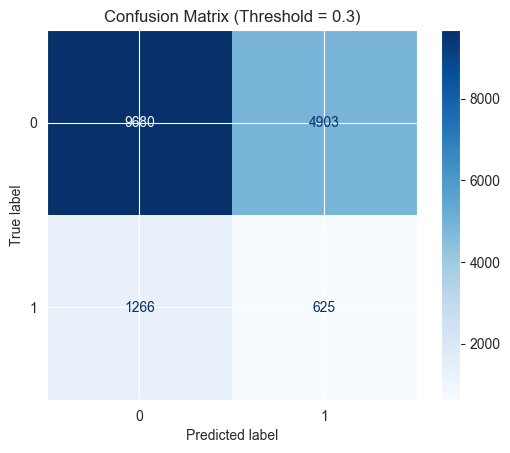

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_thresh)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.show()

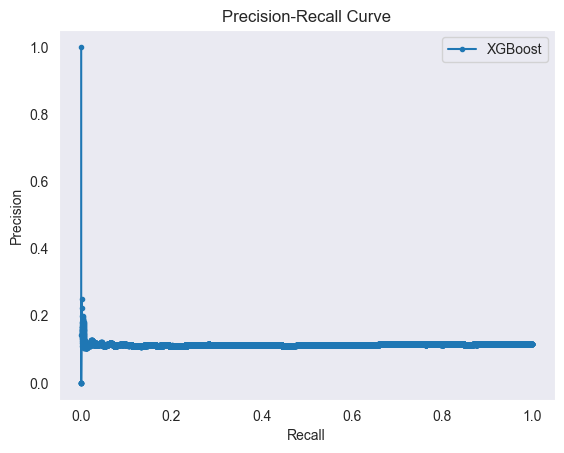

In [91]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision, marker='.', label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

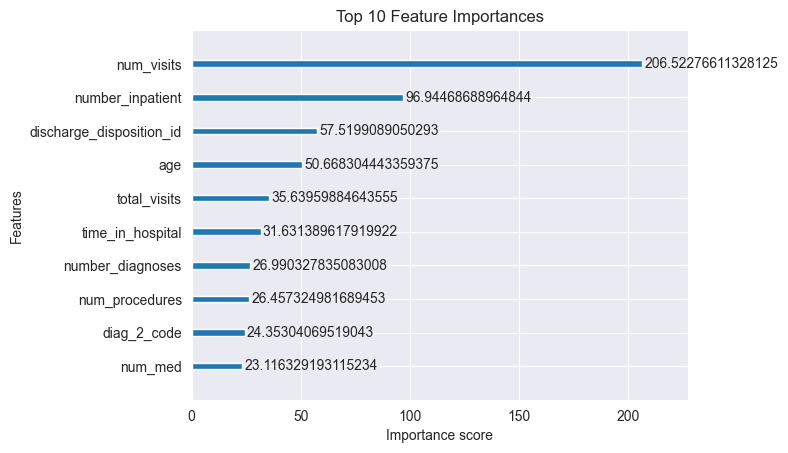

In [92]:
xgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.title('Top 10 Feature Importances')
plt.show()